In [14]:
import pandas as pd 
import numpy as np 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [15]:
text_data = pd.read_csv('Data/my_UNSW_NB15_training-set.csv') 

In [16]:
text_data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [17]:
text_data.shape

(175341, 45)

In [5]:
text_data.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [19]:
text_data['state'].values

array(['FIN', 'FIN', 'FIN', ..., 'INT', 'INT', 'INT'], dtype=object)

In [16]:
text_data['dbytes'].value_counts()

dbytes
0         84282
268       11512
354        9865
178        4988
10168      2938
          ...  
799648        1
169775        1
36372         1
258592        1
426483        1
Name: count, Length: 6660, dtype: int64

In [7]:
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

In [8]:
print(text_data['label'].value_counts())

label
1    119341
0     56000
Name: count, dtype: int64


In [9]:
# features (drop target)
X = text_data.drop('label', axis=1) 

# Target
y = text_data['label']

In [10]:
#Splite train set from test set. 70%  train, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify =y)

# why for stratifying y: is to keep the same attack/normal ratio in train and test sets
# important because our data set is inbalance

In [11]:
# Labels encoding to change them to numeric values.
categorical_cols = ['proto', 'service', 'state']

#encoding the columns using the odinal encoder 
encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value =-1)
X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols])

X_test[categorical_cols] = encoder.transform(X_test[categorical_cols])

X_train.columns =X_train.columns.astype(str)
X_test.columns =X_test.columns.astype(str)

drop_cols = ['scrip', 'dstip', 'attack_cat']

# drop only the columns that exist 

drop_cols_existing = [col for col in drop_cols if col in X_train.columns]

X_train = X_train.drop(drop_cols_existing, axis = 1)
X_test = X_test.drop(drop_cols_existing, axis = 1)

## Returning this model to reduce or remove overfitting
    My first model appared to be over fitted 
    with Training Accuracy: 1 
    and Test Accuracy: 0.98 
    shows that model was overfitted such that it memorized everything including the noice 

    I will be using max_depth and min_sample_leaf for resolve the problem

In [12]:
# Decision tree Training.
# 1 Initialize the model 
dt_model_tuned = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 50, random_state=42 ) 
# this prevent the three from growing to deep and each leaf must have atlist 50 samples 
#dt_model = DecisionTreeClassifier(random_state=42)

#print(y_train.dtype)
#print(y_train.unique())
#print('Missing values in X_train: ', X_train.isnull().sum().sum())
#print('Missing values in y_train: ', y_train.isnull().sum().sum())
#print("--------------------")
#print("infinite value in X_train: ", np.isinf(X_train).sum().sum())
#print("infinite value in y_train: ", np.isinf(y_train).sum().sum())

#print(X_train.shape)
#print(y_train.shape)

#


#Training the model 
dt_model_tuned.fit(X_train, y_train)

# Make prediction 
y_pred_tuned = dt_model_tuned.predict(X_test)

In [48]:
print("Accuracy: ", accuracy_score(y_test, y_pred_tuned))
print(confusion_matrix(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned))

Accuracy:  0.9765412619052145
[[15687  1113]
 [  121 35682]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     16800
           1       0.97      1.00      0.98     35803

    accuracy                           0.98     52603
   macro avg       0.98      0.97      0.97     52603
weighted avg       0.98      0.98      0.98     52603



In [13]:
print("Training Accuracy: ", dt_model_tuned.score(X_train, y_train))
print("Test accuracy: ", accuracy_score(y_test, y_pred_tuned))
print('confusion Matrix: \n', classification_report(y_test, y_pred_tuned))
print("Classification report: \n", classification_report(y_test, y_pred_tuned))

Training Accuracy:  0.9756880509703596
Test accuracy:  0.9765412619052145
confusion Matrix: 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96     16800
           1       0.97      1.00      0.98     35803

    accuracy                           0.98     52603
   macro avg       0.98      0.97      0.97     52603
weighted avg       0.98      0.98      0.98     52603

Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96     16800
           1       0.97      1.00      0.98     35803

    accuracy                           0.98     52603
   macro avg       0.98      0.97      0.97     52603
weighted avg       0.98      0.98      0.98     52603



## Classification report summary 

###### Class 0 (smaller class) is slightly harder to predict correctly — common in imbalanced datasets.
###### Class 1 (larger class) is predicted nearly perfectly.
###### Overall, the model is very strong, with minimal misclassification.


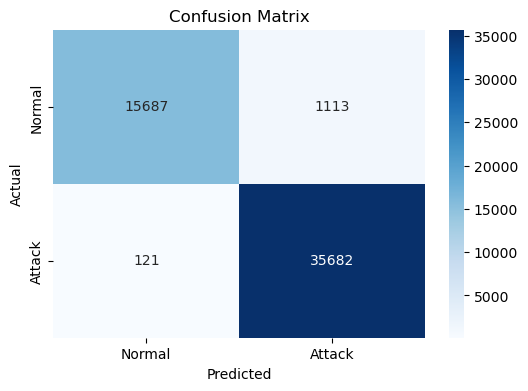

In [20]:
# Visualizing the confusion matrix
cm = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Attack'], yticklabels=['Normal','Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Confusion Matrix

A confusion matrix is a table that shows how well your model predicts each class. In your case:

###### Predicted \ Actual	Normal (0)	      Attack (1)
###### Normal (0)	True Negatives (TN)	      False Negatives (FN)
###### Attack (1)	False Positives (FP)	  True Positives (TP)

### True Negative (TN): Correctly predicted normal traffic

False Negative (FN): Attack predicted as normal (missed attack)

False Positive (FP): Normal predicted as attack (false alarm)

True Positive (TP): Correctly predicted attack traffic

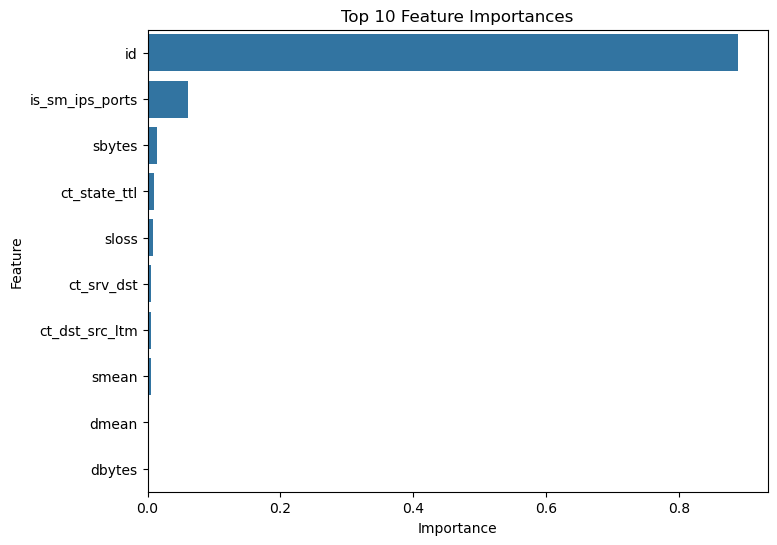

In [21]:
# Featurs important 

feature_importances = dt_model_tuned.feature_importances_
features = X_train.columns

feat_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(10))  # Top 10 features
plt.title('Top 10 Feature Importances')
plt.show()

### Feature importance tells you which input variables (network attributes) the Decision Tree relied on most to make predictions.

Each network feature (e.g., protocol, port number, payload size) gets a score
Higher score → more influence on predicting attacks
Helps you understand the model and justify decisions

### Why it matters:

Identifies critical network features for attack detection
Guides security monitoring and feature selection
Makes your model interpretable, not just a black box